<a href="https://colab.research.google.com/github/euguroglu/Machine-Learning-Projects/blob/master/Pytorch_ANN_Text_Recognition_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [78]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [80]:
# Mnist image --> Tensors
transform = transforms.ToTensor()

## Importing data

In [81]:
train_data = datasets.MNIST(root='' ,train=True,download=True,transform=transform)

In [82]:
test_data = datasets.MNIST(root='', train=False,download=True,transform=transform)

## Checking data structure

In [83]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [84]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [85]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [86]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [87]:
image,label = train_data[0] # we wrote that to understand first index of the tensor on dataset
image.shape  # 1 is because this is grayscale image

torch.Size([1, 28, 28])

In [88]:
label

5

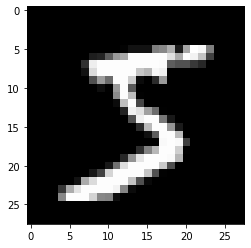

In [89]:
plt.imshow(train_data[0][0].reshape(28,28),cmap='gray')

In [90]:
torch.manual_seed(101)

## Train test split and specifying batch size

In [91]:
train_loader = DataLoader(train_data,batch_size=100,shuffle=True) #If batch size can not evenly divisible by data size, remain data will be shuffled after every epoch!!
test_loader = DataLoader(test_data,batch_size=500,shuffle=False)

In [92]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x:f'{x:4}'))

In [93]:
for images,labels in train_loader:
  break #break to get only first batch data for visualization


In [94]:
images.shape

torch.Size([100, 1, 28, 28])

In [95]:
labels.shape

torch.Size([100])

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


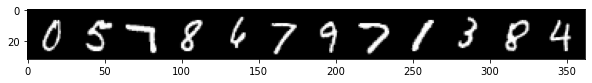

In [96]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Multilayer Neural Network

In [98]:
class MultilayerPerceptron(nn.Module):

  def __init__(self,in_sz=784,out_sz=10,layers=[120,84]):

    super().__init__()

    self.fc1 = nn.Linear(in_sz,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],out_sz)

  def forward(self,X):

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X,dim=1) # Because multiclass classification

In [99]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Code to obsever model paramters numbers

In [100]:
for param in model.parameters():
  print(param.numel())

94080
120
10080
84
840
10


## Defining cost function and optimization method

In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [102]:
images.shape # ----> [100,784]

torch.Size([100, 1, 28, 28])

In [103]:
images.view(100,-1).shape # -1 means combine other dimensions after 100

torch.Size([100, 784])

## Training

In [104]:
import time
start_time = time.time()

#Training

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):

  trn_corr = 0
  tst_corr = 0

  for b, (X_train,y_train) in enumerate(train_loader):

    b = b + 1

    y_pred = model(X_train.view(100,-1))  # Here we flatten X_train
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr = trn_corr + batch_corr
   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%200 == 0:
      accuracy = trn_corr.item()*100/(100*b)
      print('Epoch:  {} Batch:  {} Loss:  {} Accuracy:  {}'.format(i,b,loss.item(),accuracy))

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():

    for b, (X_test,y_test) in enumerate(test_loader):

      y_val = model(X_test.view(500,-1))
      predicted = torch.max(y_val.data,1)[1]
      tst_corr = tst_corr + (predicted==y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch:  0 Batch:  200 Loss:  0.2758258581161499 Accuracy:  83.09
Epoch:  0 Batch:  400 Loss:  0.2167152464389801 Accuracy:  87.3725
Epoch:  0 Batch:  600 Loss:  0.21335364878177643 Accuracy:  89.38833333333334
Epoch:  1 Batch:  200 Loss:  0.1393900364637375 Accuracy:  94.71
Epoch:  1 Batch:  400 Loss:  0.12105043232440948 Accuracy:  95.2
Epoch:  1 Batch:  600 Loss:  0.1198485866189003 Accuracy:  95.42666666666666
Epoch:  2 Batch:  200 Loss:  0.12427228689193726 Accuracy:  96.57
Epoch:  2 Batch:  400 Loss:  0.09284494072198868 Accuracy:  96.69
Epoch:  2 Batch:  600 Loss:  0.09022000432014465 Accuracy:  96.765
Epoch:  3 Batch:  200 Loss:  0.043112386018037796 Accuracy:  97.575
Epoch:  3 Batch:  400 Loss:  0.07867330312728882 Accuracy:  97.555
Epoch:  3 Batch:  600 Loss:  0.045769594609737396 Accuracy:  97.56
Epoch:  4 Batch:  200 Loss:  0.14654836058616638 Accuracy:  97.87
Epoch:  4 Batch:  400 Loss:  0.10826043784618378 Accuracy:  97.9425
Epoch:  4 Batch:  600 Loss:  0.14401523768901825

## Visualization

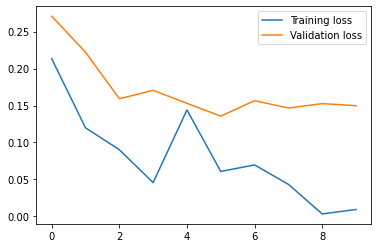

In [110]:
plt.plot(range(epochs),train_losses,label='Training loss')
plt.plot(range(epochs),test_losses,label='Validation loss')
plt.legend()

In [121]:
train_acc = [t//600 for t in train_correct]
train_acc

[tensor(89),
 tensor(95),
 tensor(96),
 tensor(97),
 tensor(97),
 tensor(98),
 tensor(98),
 tensor(98),
 tensor(99),
 tensor(99)]

In [123]:
test_acc = [t//100 for t in test_correct]

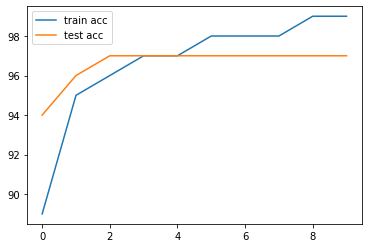

In [124]:
plt.plot(train_acc,label='train acc')
plt.plot(test_acc,label='test acc')
plt.legend()

## Checking completely new data

In [125]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [127]:
with torch.no_grad():
  correct = 0

  for X_test,y_test in test_load_all:
    y_val = model(X_test.view(len(X_test),-1))
    predicted = torch.max(y_val,1)[1]
    correct = correct + (predicted==y_test).sum()

In [131]:
correct.item()/len(test_data)*100

97.69

In [138]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 967,    0,    1,    1,    2,    2,    5,    1,    5,    2],
       [   0, 1122,    3,    1,    0,    0,    3,    3,    0,    2],
       [   2,    3, 1008,    0,    1,    0,    2,    7,    2,    0],
       [   3,    2,    6,  998,    1,   15,    1,    1,    3,    7],
       [   1,    0,    2,    0,  967,    2,   11,    1,    3,   13],
       [   0,    1,    0,    2,    0,  864,    6,    0,    4,    4],
       [   1,    2,    1,    0,    3,    3,  927,    0,    1,    0],
       [   1,    1,    2,    4,    2,    1,    0, 1012,    6,   17],
       [   4,    4,    9,    3,    2,    5,    3,    2,  947,    7],
       [   1,    0,    0,    1,    4,    0,    0,    1,    3,  957]])